# 25/11/2020

## Détecteurs de Sobel et de Canny

Les objectifs de cet exercice sont de :
* détecter des contours en utilisant les détecteurs de Sobel et de Canny
* comprendre l'influence des paramètres de ces méthodes
* comparer ces méthodes en termes de temps de calcul

In [1]:
from skimage.io import imread
from skimage.filters import sobel, sobel_h, sobel_v
from skimage.feature import canny

from matplotlib.pyplot import figure, imshow, title, subplot, plot, show, plot, xlabel, ylabel, axis

import time

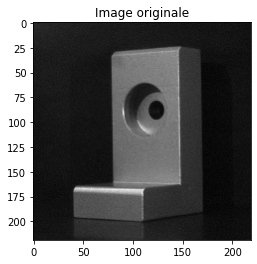

In [2]:
x = imread("L.png")
x = x / 255
figure
imshow(x, cmap="gray")
title("Image originale");

### Détecteur de Sobel

Le filtre de Sobel effectue une convolution de l'image par deux filtres, chacun permettant d'obtenir le gradient de l'image dans les deux dimensions. Ces deux gradients peuvent être fusionnés pour aboutir à l'image de contours ci-dessous à droite (comment est effectuée cette fusion ?).

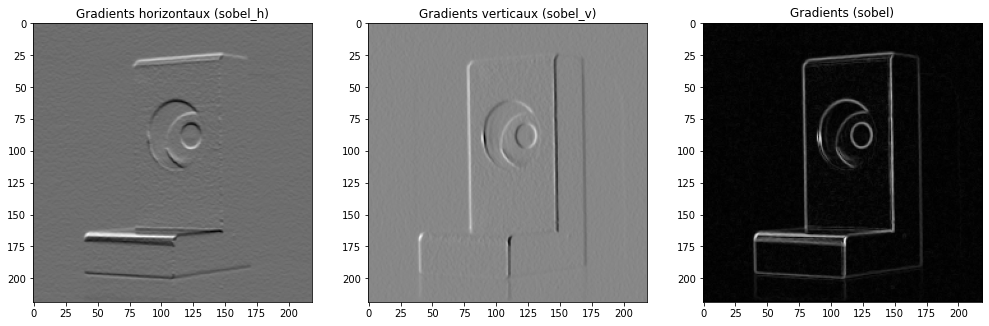

In [3]:
figure(figsize=(17,10))

subplot(1,3,1)
imshow(sobel_h(x), cmap="gray")
title("Gradients horizontaux (sobel_h)")

subplot(1,3,2)
imshow(sobel_v(x), cmap="gray")
title("Gradients verticaux (sobel_v)")

subplot(1,3,3)
imshow(sobel(x), cmap="gray")
title("Gradients (sobel)")

show()

L'image de gradient peut être seuillée pour identifier les contours principaux. Les résultats pour trois valeurs de seuil sont donnés ci-dessous.

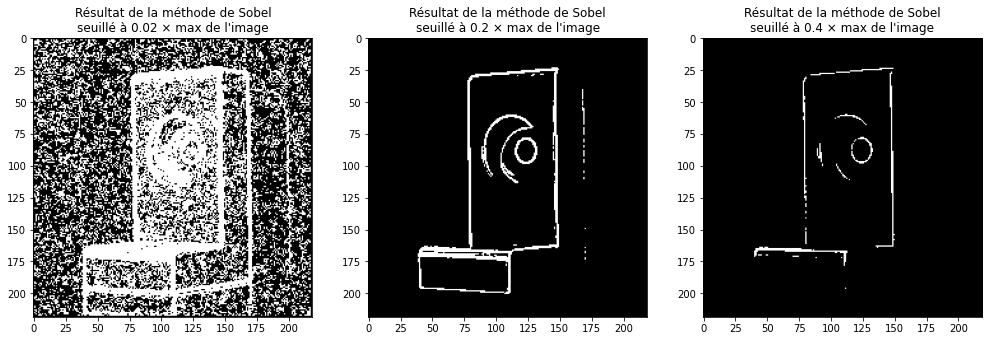

In [4]:
y = sobel(x)
seuils = [.02, .20, .40]

figure(figsize=(17,10))
for i, seuil in enumerate(seuils):
    z = y > seuil*y.max()
    subplot(1,3,i+1)
    imshow(z, cmap="gray")
    title("Résultat de la méthode de Sobel\nseuillé à {} × max de l'image".format(seuil))

* On constate tout d'abord que plus le seuil est élevé, moins il y a de contours détectés
  (il y a moins de pixels blancs).
  Cela s'explique par le fait que moins de pixels auront un gradient supérieur au seuil,
  et donc seront considérés comme des contours.
* Lorsque le seuil est trop bas, des contours sont détectés partout.
  En particulier, le fond de l'image étant (légèrement) bruité, des contours peuvent y être détectés.
* Au contraire, lorsque le seuil est trop haut, il y a beaucoup de non-détections
  même s'il n'y a presque plus de fausses alarmes.
* Par ailleurs, même en fixant le seuil assez haut, certains contours sont très larges :
  ils ont une largeur de plusieurs pixels, ce qui implique que le contour, bien que détecté,
  n'est pas positionné avec précision.

### Détecteur de Canny

Le détecteur de Canny est plus complexe qu'un simple filtrage. Il comporte notamment un seuillage par hystérésis, c'est-à-dire une décision basée sur deux seuils $s_{bas}$ et $s_{haut}$ :
* les pixels d'intensité inférieure à $s_{bas}$ ne seront pas détectés,
* les pixels d'intensité supérieure à $s_{haut}$ seront détectés comme des contours,
* les pixels d'intensité comprise entre $s_{bas}$ et $s_{haut}$ seront détectés comme des contours uniquement si ils sont voisins d'autres contours.

**Étude de l'influence de la largeur de la gaussienne (paramètre `sigma`)**

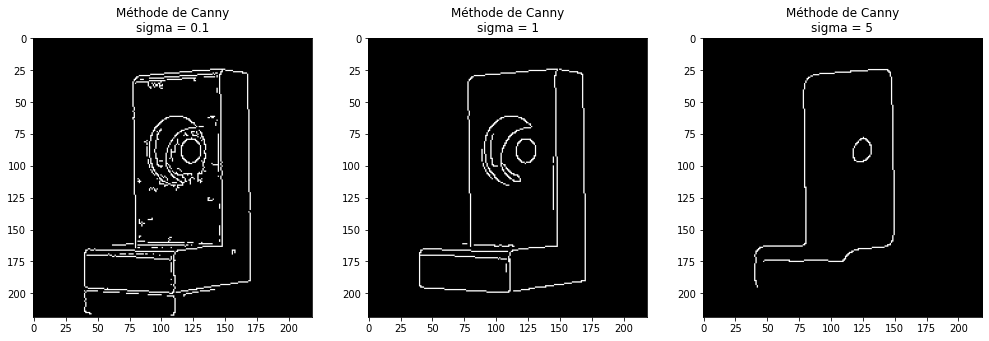

In [5]:
sigs = [0.1, 1, 5]
figure(figsize=(17,10))
for i, sig in enumerate(sigs):
    z = canny(x, sigma=sig)
    subplot(1,3,i+1)
    imshow(z, cmap="gray")
    title("Méthode de Canny\nsigma = {}".format(sig))

On observe que lorsque `sigma` augmente, le nombre de contours détecté est plus faible. Cela s'explique par le fait que la première étape du détecteur de Sobel est un filtrage de l'image par un filtre gaussien d'écart type `sigma` pour adoucir le bruit. En contrepartie, l'image est plus floue et donc les contours sont moins marqués : ils sont donc plus difficiles à détecter.

**Étude de l'influence du seuil bas (paramètre `low_threshold`)**

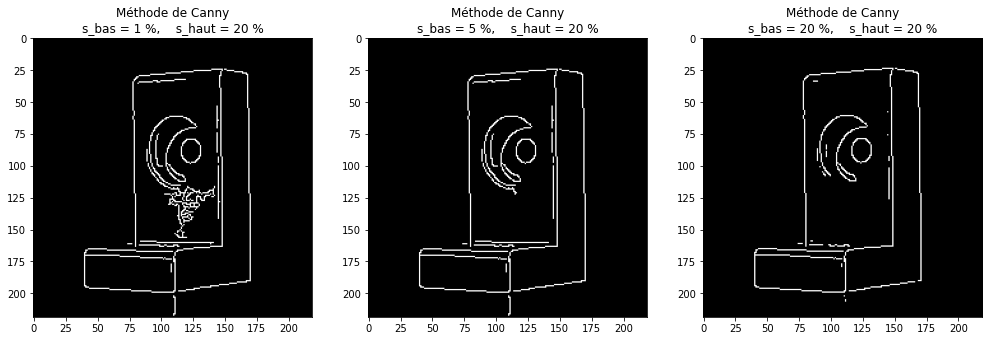

In [6]:
seuils = [0.01, 0.05, 0.2]
seuil_haut = 0.2
figure(figsize=(17,10))
for i, seuil_bas in enumerate(seuils):
    z = canny(x, low_threshold=seuil_bas*x.max(), high_threshold=seuil_haut*x.max())
    subplot(1,3,i+1)
    imshow(z, cmap="gray")
    title("Méthode de Canny\ns_bas = {:.0f} %,    s_haut = {:.0f} %".format(seuil_bas*100, seuil_haut*100))

Lorsque le seuil bas augmente, le nombre de contours détecté diminue, puisqu'il y aura moins de pixels dont la valeur du gradient sera supérieure au seuil bas.

**Étude de l'influence du seuil haut (paramètre `high_threshold`)**

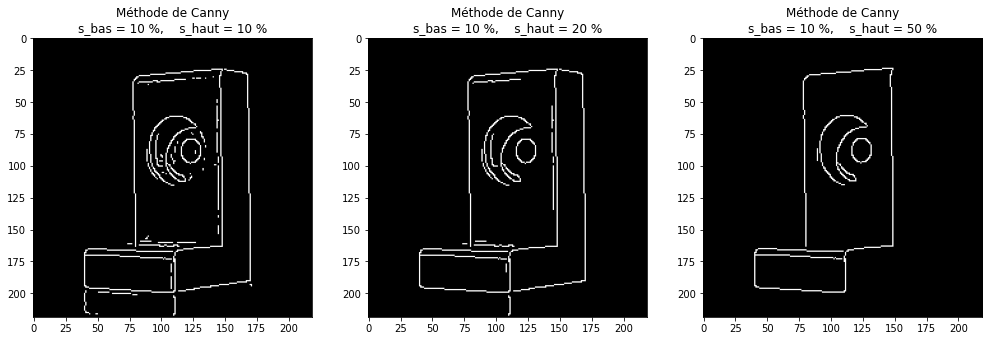

In [7]:
seuils = [0.1, 0.2, 0.5]
seuil_bas = 0.1
figure(figsize=(17,10))
for i, seuil_haut in enumerate(seuils):
    z = canny(x, low_threshold=seuil_bas*x.max(), high_threshold=seuil_haut*x.max())
    subplot(1,3,i+1)
    imshow(z, cmap="gray")
    title("Méthode de Canny\ns_bas = {:.0f} %,    s_haut = {:.0f} %".format(seuil_bas*100, seuil_haut*100))

Comme précédemment, plus le seuil haut augmente, moins il y a de contours détectés.

En conclusion, on observe que le nombre de contours détectés diminue avec la valeur des seuils, comme pour le détecteur de Sobel. En revanche, le détecteur de Canny produit des contours fins et majoritairement continus : la détection est donc plus claire et plus précise.

### Comparaison des deux méthodes en termes de temps de calcul

L'une des étapes du détecteur de Canny est d'appliquer un filtre de Sobel.
Par conséquent, on s'attend à ce que le détecteur de Canny soit plus lent que le détecteur de Sobel.
Pour cela, on mesure le temps nécessaire à chaque méthode pour détecter les contours de l'image.

Pour des raisons informatiques, les résultats ne sont pas parfaitement reproductibles :
si vous lancez deux fois la comparaison, les temps de calcul vont différer légèrement.
Aussi, dans l'exemple ci-dessous, les temps de calcul sont mesurés sur 100 simulations.

In [8]:
I = 100           # Nombre de simulations
total_sobel = 0   # Temps total pour les I simulations pour le détecteur de Sobel
total_canny = 0   # Temps total pour les I simulations pour le détecteur de Canny

for i in range(I):
    
    # Temps de calcul du détecteur de Sobel
    tic = time.time()
    y = sobel(x)
    z = y > 0.5*y.max() # N'oubliez pas de prendre en compte le seuillage !
    tac = time.time()
    tps_sobel = tac-tic
    total_sobel += tps_sobel
    
    # Temps de calcul du détecteur de Canny
    tic = time.time()
    z = canny(x)
    tac = time.time()
    tps_canny = tac-tic
    total_canny += tps_canny
    
    # Affichage du temps de calcul des deux méthodes (pour les 10 premières simulations)
    if i<10:
        print(f"Sobel : {tps_sobel*1e3:.3f} ms     Canny : {tps_canny*1e3:.3f} ms")
    elif i==10:
        print("etc.")
    
print("\nLe détecteur de Canny est donc, en moyenne, "
      + f"environ {total_canny/total_sobel:.0f} fois plus lent que le détecteur de Sobel.")

Sobel : 1.624 ms     Canny : 13.765 ms
Sobel : 1.655 ms     Canny : 29.367 ms
Sobel : 2.108 ms     Canny : 23.828 ms
Sobel : 1.978 ms     Canny : 16.250 ms
Sobel : 1.861 ms     Canny : 13.845 ms
Sobel : 1.542 ms     Canny : 13.039 ms
Sobel : 1.416 ms     Canny : 12.851 ms
Sobel : 1.379 ms     Canny : 12.284 ms
Sobel : 1.370 ms     Canny : 12.117 ms
Sobel : 1.307 ms     Canny : 11.786 ms
etc.

Le détecteur de Canny est donc, en moyenne, environ 9 fois plus lent que le détecteur de Sobel.


Nous avions vu juste, le détecteur de Canny est plus lent que le détecteur de Sobel.
Cependant, le temps de calcul reste très acceptable pour des images de taille classique (environ 15 ms),
donc finalement la différence de temps entre les deux méthodes n'est pas préjudiciable dans la majorité des applications.

## Détecteur de Harris

L'objectif de cet exercice est de détecter des coins à l'aide du détecteur de Harris.

In [9]:
from skimage.io import imread
from skimage.feature import corner_harris, corner_peaks

from matplotlib.pyplot import figure, imshow, title, subplot, plot, show, plot, xlabel, ylabel, axis, colorbar, clim

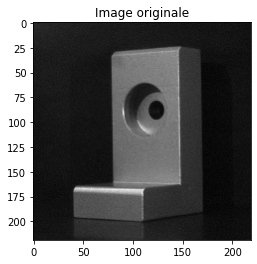

In [10]:
x = imread("L.png")
x = x / 255
figure
imshow(x, cmap="gray")
title("Image originale")
show()

Le détecteur de Harris permet de détecter les coins d'une image, en se basant sur les différences d'intensité.

Avec la fonction `corner_harris`, choisissez `method='k'` et une valeur de $k$ comprise entre 0 et 0,2. Il en résulte une nouvelle image, de même taille que l'image à analyser, dont les intensités sont proportionnelles à la présence d'un coin.

Dans les images ci-dessous, les intensités sont retreintes à l'intervalle $[-0.4, 0.4]$ afin de bien faire ressortir les valeurs de l'image

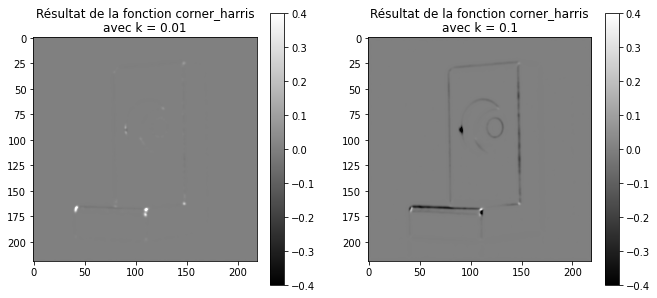

In [11]:
ks = [.01, .10]
figure(figsize=(17,5))
for i, k in enumerate(ks):
    
    y = corner_harris(x, method='k', k=k, sigma=1)
    
    subplot(1,3,i+1)
    imshow(y, cmap="gray")
    clim(-0.4, 0.4)
    colorbar()
    title("Résultat de la fonction corner_harris\navec k = {}".format(k))

La fonction `corner_peaks` retourne les coordonnées des valeurs fortes de l'image, qui correspondent aux coins. Ces coordonnées sont retournées sous forme de matrice dont la première colonne correspond aux ordonnées, la seconde aux abscisses.

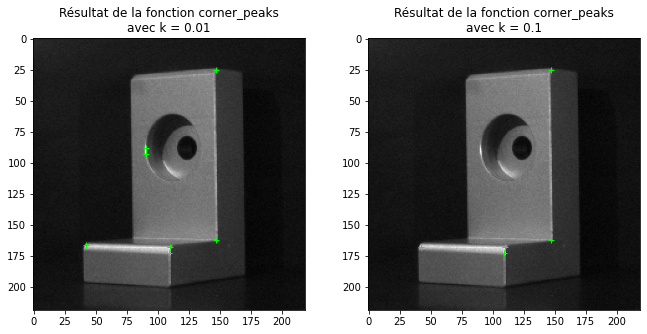

In [12]:
ks = [.01, .10]
figure(figsize=(17,5))
for i, k in enumerate(ks):
    
    y = corner_harris(x, method='k', k=k, sigma=1)
    coords = corner_peaks(y)
    
    subplot(1,3,i+1)
    imshow(x, cmap="gray")
    plot(coords[:,1], coords[:,0], color='lime', marker='+', linestyle='none')
    title("Résultat de la fonction corner_peaks\navec k = {}".format(k))

Les images ci-dessus correspondent au résultat obtenu pour deux valeurs de $k$.
Lorsque le paramètre est suffisamment grand, seuls les coins les plus francs sont détectés :
on l'observe bien sur l'image de droite.

Cependant, tous les coins de l'objet ne sont pas détectés : comment améliorer le résultat ?

De plus, quelques points ne correspondent pas à des coins de l'objet.
Mais à y regarder de plus près, ils correspondent à des pixels d'intensité très différente de leurs voisins,
ce qui est la définition d'un coin pour Harris.
Par exemple, un zoom au niveau du trou de l'objet est représenté ci-dessous pour la première valeur de $k$ testée.

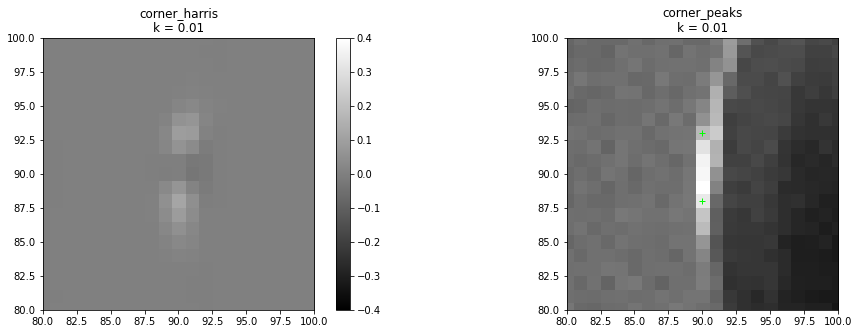

In [13]:
k = 0.01
y = corner_harris(x, method='k', k=k, sigma=1)
coords = corner_peaks(y)

figure(figsize=(17,5))

subplot(1,2,1)
imshow(y, cmap="gray")
axis([80, 100, 80, 100])
clim(-0.4, 0.4)
colorbar()
title("corner_harris\nk = {}".format(k))

subplot(1,2,2)
imshow(x, cmap="gray")
plot(coords[:,1], coords[:,0], color='lime', marker='+', linestyle='none')
axis([80, 100, 80, 100])
title("corner_peaks\nk = {}".format(k))
show()

D'après la définition d'un coin utilisée par Harris, il s'agit bien de coins que l'on observe ici...

## Transformée de Hough

Les objectifs de cet exercice sont : 
* de détecter des lignes dans une image avec la transformée de Hough
* de savoir interpréter une transformée de Hough

In [14]:
from math import pi

from numpy import cos, sin, rad2deg

from skimage.io import imread
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks

from matplotlib.pyplot import figure, imshow, title, subplot, plot, show, plot, xlabel, ylabel, axis, axis

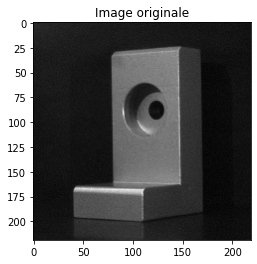

In [15]:
x = imread("L.png")
x = x /255
figure
imshow(x, cmap="gray")
title("Image originale")
show()

La transformée de Hough s'applique sur des images binaires, qui doivent mettre en évidence les droites de l'image.
Aussi, une détection de contours semble tout à fait adaptée.
On applique donc le détecteur de Canny (ici, avec les paramètres par défaut) sur l'image puisque,
comme on l'a vu, il donne de meilleurs résultats que le détecteur de Sobel.

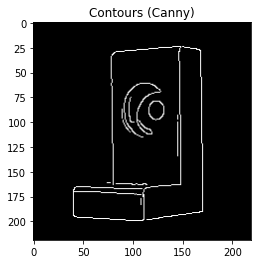

In [16]:
y = canny(x)
figure
imshow(y, cmap="gray")
title("Contours (Canny)")
show()

La méthode `hough_line` retourne l'accumulateur (la représentation de la transformée sur l'image) et les axes des abscisses et ordonnées correspondants.

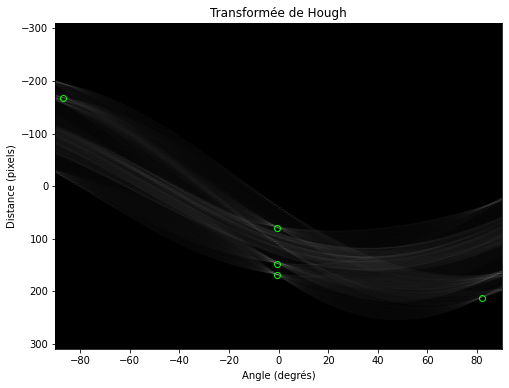

In [17]:
accumulator, angle, dist  = hough_line(y)
peaks, angles, dists = hough_line_peaks(accumulator, angle, dist, num_peaks=6)

axes = (rad2deg(angle[0]), rad2deg(angle[-1]), dist[-1], dist[0])

figure(figsize=(8,6))
imshow(accumulator, cmap="gray", extent=axes, aspect="auto")
xlabel('Angle (degrés)')
ylabel('Distance (pixels)')
title("Transformée de Hough")
plot(rad2deg(angles), dists, marker='o', markeredgecolor='lime', markerfacecolor="none", linestyle="none")
show()

Le résultat obtenu fait bien apparaître des sinusoïdes,
chacune correspondant à un pixel blanc de l'image des contours.
Lorsque les sinusoïdes se croisent, elles augmentent l'intensité du pixel du croisement.
Les pixels les plus lumineux de la transformée correspondent aux droites principales de l'image de contours.
La fonction `hough_line_peak` permet de mettre en évidence ces pixels :
les plus importants sont représentés par les cercles verts sur l'accumulateur,
et correspondent aux lignes représentées sur l'image ci-dessous.

En revanche, bien que le nombre de pics recherchés est fixé à 6, seuls 5 points sont trouvés.

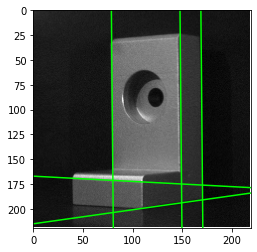

In [18]:
M, N = x.shape

figure
imshow(x, cmap="gray")

for _, angle, dist in zip(peaks, angles, dists):
    
    # Coordonnée de la ligne
    x0 = 0
    y0 = dist / sin(angle)
    x1 = N
    y1 = (dist - x1*cos(angle)) / sin(angle)
    
    # Tracé de la ligne
    plot((x0, x1), (y0, y1), color='lime')

axis((0,N,M,0))
show()

Sauriez-vous identifier sur l'accumulateur où se trouvent les lignes restantes de l'image ?

Tentez de détecter le rond central de l'objet.